In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import MobileNetV2  # You can use MobileNetV2 as a placeholder for GhostNet


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define the image size
IMAGE_SIZE = (224, 224)


In [ ]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [ ]:
# Import a placeholder model (MobileNetV2) for GhostNet
ghostnet = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)


In [ ]:
# Freeze all layers in the GhostNet model
for layer in ghostnet.layers:
    layer.trainable = False


In [ ]:
# Get the folders in the training data directory
folders = glob('chest_xray/train/*')


In [ ]:
# Add a flatten layer and a dense layer to the GhostNet model
x = Flatten()(ghostnet.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [ ]:
# Create a model object
model = Model(inputs=ghostnet.input, outputs=prediction)


In [ ]:
# View the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=10, class_mode='categorical')
test_set = test_datagen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=10, class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Train the model
model.fit(
    training_set,
    validation_data=test_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


522/522 [==============================] - 64s 119ms/step - loss: 1.2655 - accuracy: 0.9248 - val_loss: 2.7183 - val_accuracy: 0.8702


In [ ]:
# Prediction for a single image
img = image.load_img('chest_xray/test/Normal/IM-0001-0001.jpeg', target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
result = int(classes[0][0])

if result == 0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")

1/1 [==============================] - 1s 670ms/step
Result is Normal


In [ ]:
# Initialize an empty list to store true and predicted labels
true_labels = []
predicted_labels = []

In [ ]:
# Loop through the test set and predict labels
for i in range(len(test_set)):
    batch = test_set[i]
    images, labels = batch
    predictions = model.predict(images)

    # Convert one-hot encoded labels to class labels
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))


1/1 [==============================] - 0s 46ms/step


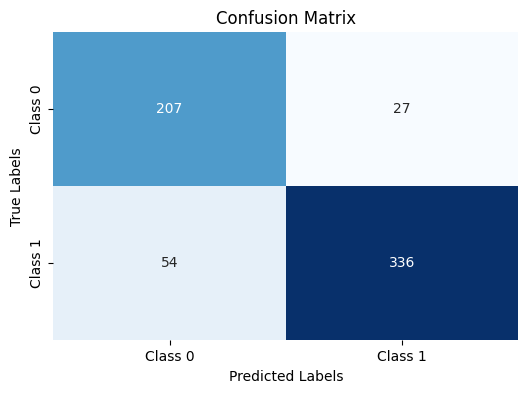

In [ ]:
# Calculate the confusion matrix, accuracy, precision, recall, and F1-score

from sklearn.metrics import confusion_matrix
import seaborn as sns


conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.yticks(np.arange(len(conf_matrix)) + 0.5, ['Class 0', 'Class 1'])  # Modify class labels accordingly
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy   :", accuracy)
precision = precision_score(true_labels, predicted_labels)
print("Precision :", precision)
recall = recall_score(true_labels, predicted_labels)
print("Recall    :", recall)
F1_score = f1_score(true_labels, predicted_labels)
print("F1-score  :", F1_score)

Accuracy   : 0.8701923076923077
Precision : 0.9256198347107438
Recall    : 0.8615384615384616
F1-score  : 0.8924302788844622
